<a href="https://colab.research.google.com/github/TajikDanyal/Brats/blob/master/ResuNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !wget https://www.cbica.upenn.edu/sbia/Spyridon.Bakas/MICCAI_BraTS/2019/MICCAI_BraTS_2019_Data_Training.zip
# from zipfile import ZipFile
# zip = ZipFile('MICCAI_BraTS_2019_Data_Training.zip')
# zip.extractall()

In [0]:
import os
import numpy as np
import nibabel as nib
import random
import matplotlib.pyplot as plt
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.utils import Sequence
import cv2
import math
np.set_printoptions(suppress=True)

In [0]:
PATH = "/content/MICCAI_BraTS_2019_Data_Training/HGG/"

In [0]:
class MyGenerator(Sequence):
    def __init__(self, Path, Directories):
        self.Path=Path
        self.Folders=Directories
    def __len__(self):
        return len(self.Folders)
    def __getitem__(self, idx):
      return ReadImageDataFromFolderFilesSingle(self.Folders[idx],idx)

In [0]:
def ReadDataset(Path):
    return os.listdir(Path)

In [0]:
def Split(Folders, Ratio=0.8):
    random.shuffle(Folders)
    Train = []
    Test = []
    Valid = []
    SplitPoint = int(Ratio*len(Folders))
    Train = Folders[0:SplitPoint]
    Test = Folders[SplitPoint:len(Folders)]
    SplitPoint = int(Ratio*len(Train))
    Valid = Train[SplitPoint:len(Train)]
    Train = Train[0:SplitPoint]
    return Train, Test, Valid

In [0]:
Folders = ReadDataset(PATH)
Train,Test,Valid = Split(Folders)
def CustomGenerator():
  count = 0
  folder_count = 0
  while(True):
    yield ReadImageDataFromFolderFilesSingle(Train[folder_count], count)
    count = count + 1
    if count is 31:
      count = 0
      folder_count = folder_count + 1


In [0]:
def SetLabel(FileName):
    if"t1." in FileName :
        return "T1"
    elif "t1ce." in FileName:
        return "T1CE"
    elif "seg." in FileName:
        return "Segmented"
    elif "flair." in FileName:
        return "Flair"
    elif "t2." in FileName:
        return "T2"
    return "Undefined"

In [0]:
def ReadImageDataFromFolderFiles(FolderName):
  
    Files = os.listdir(PATH+FolderName)
    Files.sort()
    Images = [nib.load( PATH+FolderName+"/"+File ).get_fdata() for File in Files]
    XData = np.zeros( (Images[0].shape[2], Images[0].shape[0], Images[0].shape[1], 4) )
    YData = np.zeros( (Images[0].shape[2], Images[0].shape[0], Images[0].shape[1], 1) )
    for i in range(Images[0].shape[2]):
        XData[i,:,:,0] = Images[0][:,:,i] 
        XData[i,:,:,1] = Images[2][:,:,i] 
        XData[i,:,:,2] = Images[3][:,:,i] 
        XData[i,:,:,3] = Images[4][:,:,i] 
        YData[i,:,:,0] = Images[1][:,:,i] 
    return XData/65535, YData/4

In [0]:
def ReadImageDataFromFolderFilesSingle(FolderName, idx):
  
    Files = os.listdir(PATH+FolderName)
    Files.sort()
    XData = nib.load( PATH+FolderName+"/"+Files[0] ).get_fdata()
    YData = nib.load( PATH+FolderName+"/"+Files[1] ).get_fdata()
    YDataC = np.zeros( (YData.shape[2], YData.shape[0], YData.shape[1]) )
    XDataC = np.zeros( (XData.shape[2], XData.shape[0], XData.shape[1]) )
    for Index in range(YData.shape[2]):
      YDataC[Index,:,:] = YData[:,:, Index]
      XDataC[Index,:,:] = XData[:,:, Index]
    #DisplayOutputSingle(XDataC[77,:,:],YDataC[77,:,:])
    #raise ValueError(YDataC.dtype)
    YDataC = np.expand_dims(YDataC,3)
    XDataC = np.expand_dims(XDataC,3)#[idx*5:(idx+1)*5-1,:,:,:]
    return (XDataC/65535)[idx*5:(idx+1)*5-1,:,:,:], (YDataC/65535)[idx*5:(idx+1)*5-1,:,:,:]

In [0]:
def DisplaySample(FolderName, index):
    print("****IN: "+str(index+1)+" PATH="+PATH+FolderName+"****")
    Files = os.listdir(PATH+FolderName)
    fig, axes = plt.subplots(1, len(Files))
    count=0
    TempFiles=Files3
    TempFiles.sort()
    for File in Files:
        img = nib.load(PATH+FolderName+"/"+File)
        #print (img)
        img_data = img.get_fdata()
        #img_data = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #raise ValueError(img_data.shape)
        axes[count].title.set_text(SetLabel(File))
        axes[count].imshow(img_data[:,:,77].T, aspect="equal",  interpolation='nearest', origin="lower")
        count+=1
    plt.show()

In [0]:
def DisplayOutput(Predicted):
  fig, axes = plt.subplots(1,1)
  for i in range(0,Predicted.shape[0]):
    plt.imshow(Predicted[i,:,:,0])
    plt.show()
        

In [0]:
def DisplayOutputSingle(Predicted, GroundTruth):
  #raise ValueError(Predicted.shape, GroundTruth.shape)
  fig, axes = plt.subplots(1,2)
  axes[0].imshow(Predicted.T)
  axes[1].imshow(GroundTruth.T)
  plt.show()
        

In [0]:
def AnimateSample(FolderName, index):
    print("****IN: "+str(index+1)+" PATH="+PATH+FolderName+"****")
    Files = os.listdir(PATH+FolderName)
    TempFiles=Files
    TempFiles.sort()
    for File in Files:
        img = nib.load(PATH+FolderName+"/"+File)
        img_data = img.get_fdata()
        #raise ValueError()
        
        for i in range(img.shape[2]):
            plt.imshow(img_data[:,:,i].T)
            plt.title(File)
            plt.show()


In [0]:
def PreProcessAndPrepareDataset(Path):
    Folders=ReadDataset(Path)
    X = np.zeros((len(Folders),155*5,240,240))
    for Folder in Folders:
        ImageList = ReadImageDataFromFolderFiles(Folder)
        ImageArray = np.asarray(ImageList)
        print(ImageArray.shape)
        ImageArray = ImageArray.reshape((155*5,240,240))
        raise ValueError(ImageArray.shape)

In [0]:
kernel = 'he_normal'
def DownSample1(Input, NumConvFilters, ConvFilterSize, MaxPoolSize, activation="relu", Padding="same"):
  conv1 = Conv2D(NumConvFilters, ConvFilterSize, activation = activation, padding = Padding, kernel_initializer=kernel)(Input)
  batchn1 = BatchNormalization()(conv1)
  act1 = Activation(activation = activation)(batchn1)
  conv2 = Conv2D(NumConvFilters, ConvFilterSize, padding = Padding, kernel_initializer=kernel)(act1)
  batchn2 = BatchNormalization()(conv2)
  act2 = Activation(activation = activation)(batchn2)
  pool1 = MaxPooling2D(pool_size=(MaxPoolSize, MaxPoolSize))(act2)
  return act2, pool1

def DownSample2(Input, NumConvFilters, ConvFilterSize, MaxPoolSize, activation="relu", Padding="same"):
  conv1 = Conv2D(NumConvFilters, ConvFilterSize, padding = Padding, kernel_initializer=kernel)(Input)
  batchn1 = BatchNormalization()(conv1)
  act1 = Activation(activation = activation)(batchn1)
  return DownSample1(act1, NumConvFilters, ConvFilterSize, MaxPoolSize, activation, Padding)
   
def UpSample2(Input, SkipConnections, NumDeConvFilters, DeConvFilterSize, UnpoolSize, activation="relu", Padding="same"):
  Unpool1 = UpSampling2D(size = (UnpoolSize,UnpoolSize))(Input)
  concat = Concatenate()([SkipConnections, Unpool1])
  conv1 = Deconvolution2D(NumDeConvFilters, DeConvFilterSize, padding = Padding, kernel_initializer=kernel)(concat)
  batchn1 = BatchNormalization()(conv1)
  act1 = Activation(activation = activation)(batchn1)
  conv2 = Deconvolution2D(NumDeConvFilters, DeConvFilterSize, padding = Padding, kernel_initializer=kernel)(act1)
  batchn2 = BatchNormalization()(conv2)
  return Activation(activation = activation)(batchn2)

def UpSample1(Input, SkipConnections, NumDeConvFilters, DeConvFilterSize, UnpoolSize, activation="relu", Padding="same"):
  Up1 = UpSample2(Input, SkipConnections, NumDeConvFilters, DeConvFilterSize, UnpoolSize, activation, Padding)
  updeconv = Deconvolution2D(NumDeConvFilters, DeConvFilterSize, padding = Padding, kernel_initializer=kernel)(Up1)
  batchn1= BatchNormalization()(updeconv)
  return Activation(activation = activation)(batchn1)


  
def BottleNeck(Input, NumConvFilters, ConvFilterSize, activation="relu", Padding="same"):
  conv1 = Conv2D(NumConvFilters, ConvFilterSize, padding = Padding, kernel_initializer=kernel)(Input)
  batchn1 = BatchNormalization()(conv1)
  act1 = Activation(activation = activation)(batchn1)
  conv2 = Conv2D(NumConvFilters, ConvFilterSize, padding = Padding, kernel_initializer=kernel)(act1)
  batchn2 = BatchNormalization()(conv2)
  return batchn2
  
  
def MyModel(InputSize, NumberOfFilters = [ 32,64, 128, 256, 512, 1024], FilterSize = 3, PoolSize = 2):
  inputs = Input(InputSize)
  #################################ENCODER NETWORK START########################
  Skip1, DS1 = DownSample1(inputs, NumberOfFilters[0], FilterSize,PoolSize) # 120
  #DisplayOutputSingle(Skip1[2,:,:,0],Skip1[3,:,:,0] )
  Skip2, DS2 = DownSample2(DS1, NumberOfFilters[1], FilterSize,PoolSize) # 60
  Skip3, DS3 = DownSample2(DS2, NumberOfFilters[2], FilterSize,PoolSize) #30
  Skip4, DS4 = DownSample2(DS3, NumberOfFilters[3], FilterSize,PoolSize) #15
  # Skip5, DS5 = DownSample2(DS4, NumberOfFilters[4],3,3)
  #################################ENCODER NETWORK END###########################
  #################################BOTTLENECK START##############################
  
  BN = BottleNeck(DS4, NumberOfFilters[5], FilterSize)
  
  #################################BOTTLENECK END################################
  #################################DECODER NETWORK START#########################
  # US1=UpSample1(BN, Skip5,NumberOfFilters[4], 3, 1)
  US2=UpSample1(BN, Skip4, NumberOfFilters[3], FilterSize, PoolSize)
  US3=UpSample1(US2, Skip3, NumberOfFilters[2], FilterSize, PoolSize)
  US4=UpSample1(US3, Skip2, NumberOfFilters[1], FilterSize, PoolSize)
  US5=UpSample2(US4, Skip1, NumberOfFilters[0], FilterSize, PoolSize)
  #################################DECODER NETWORK END###########################
  #################################OUTPUT  LAYER START###########################
  Out = Conv2D(1, 1, activation = 'sigmoid')(US5)
  #################################OUTPUT LAYER END##############################
  model = Model(input = inputs, output = Out)
  
  model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
  model.summary()
  return model

In [0]:
Folders = ReadDataset(PATH)

# Train, Test, Valid = Split(Folders, 0.8)
# TrainGenerator = MyGenerator(PATH, Train)
# ValidGenerator = MyGenerator(PATH, Valid)
TestGenerator = MyGenerator(PATH, Test)

#from keras.utils import plot_model
#plot_model(Model, to_file='model.png')

#for Index, Folder in enumerate(Folders):
#     AnimateSample(Folders[0], 0)


In [0]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
#callbacks=[es]

In [26]:
Model=MyModel(InputSize = (240,240,1))












Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 240, 240, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 240, 240, 32) 0           batch_normalization_1[0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [0]:
Model.fit_generator(CustomGenerator(), steps_per_epoch= (165*30), epochs = 4, verbose = 1)

Epoch 1/4
1536/4950 [========>.....................] - ETA: 21:58 - loss: 7.1319e-04 - acc: 0.9903

In [0]:
from keras import models as mod
LayersOutput = [Layer.output for Layer in Model.layers[1:len(Model.layers)-2]]
_Model = mod.Model(inputs=Model.inputs, outputs = LayersOutput)


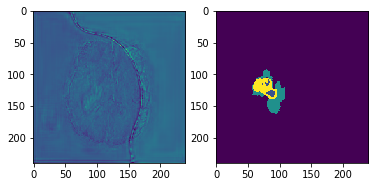

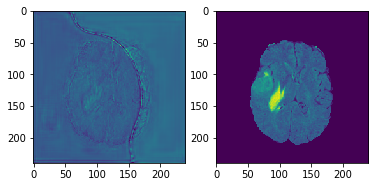

In [56]:

TDX, TDY = TestGenerator.__getitem__(1)

#raise ValueError(TDX.shape)
#Activations = _Model.predict(np.expand_dims(TDX[0],0))
Out = Model.predict(np.expand_dims(TDX[77,:,:,:],0))
# raise ValueError(Out.shape, TDY.shape)
DisplayOutputSingle(Out[0,:,:,0],TDY[77,:,:,0])
DisplayOutputSingle(Out[0,:,:,0],TDX[77,:,:,0])

float64


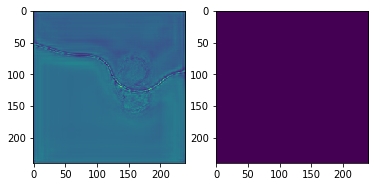

In [30]:
# plt.hist(np.squeeze(Out[0],2)*65535)
fig, axes = plt.subplots(1,2)
axes[0].imshow(Out[3,:,:,0]*10)
print(TDY.dtype)
# print()
axes[1].imshow(TDY[0,:,:,0])


In [0]:
def DisplayOutputMultiple(ImageList):
  #raise ValueError(Predicted.shape, GroundTruth.shape)
  fig, axes = plt.subplots(1,len(ImageList))
  for Index,Image in enumerate(ImageList):
    axes[Index].imshow(Image)
  plt.show()

In [32]:
names = [Layer.name for Layer in Model.layers[1:len(Model.layers)]]
Activations[0].shape
index = 16
for Act in Activations:
  print(names[index])
  OP=np.squeeze(Activations[index],0)
  DisplayOutputMultiple([OP[:,:,i] for i in range(0,20)])
  break

NameError: ignored

In [0]:
np.unique(Out)


In [0]:

np.unique(TDY*65535,return_counts=True)